In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import defaultdict
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder

In [2]:
# Prepare your data
# For this example, let's assume you have the following data:
# - `poincare_data`: a list of tuples representing parent-child relationships
# - `word2vec_data`: a list of sentences for learning Word2Vec embeddings

poincare_data = [('mammal', 'dog'), ('mammal', 'cat'), ('reptile', 'snake')]
word2vec_data = [['mammal', 'dog', 'barks'], ['mammal', 'cat', 'meows'], ['reptile', 'snake', 'hisses']]

In [3]:
# Encode words as integers
word_set = set()
for rel in poincare_data:
    word_set.add(rel[0])
    word_set.add(rel[1])

for sent in word2vec_data:
    word_set.update(sent)

In [4]:
le = LabelEncoder()
le.fit(list(word_set))

LabelEncoder()

In [5]:
vocab_size = len(word_set)
embedding_size = 100

In [6]:
# Custom Dataset
class CombinedDataset(Dataset):
    def __init__(self, poincare_data, word2vec_data, le):
        self.poincare_data = poincare_data
        self.word2vec_data = word2vec_data
        self.le = le

    def __len__(self):
        return len(self.poincare_data) + len(self.word2vec_data)

    def __getitem__(self, idx):
        if idx < len(self.poincare_data):
            parent, child = self.poincare_data[idx]
            return {'type': 'poincare', 'parent': self.le.transform([parent])[0], 'child': self.le.transform([child])[0]}
        else:
            idx -= len(self.poincare_data)
            context = self.word2vec_data[idx]
            target = context.pop(np.random.randint(len(context)))
            context = self.le.transform(context)
            target = self.le.transform([target])[0]
            return {'type': 'word2vec', 'context': context, 'target': target}

In [7]:
dataset = CombinedDataset(poincare_data, word2vec_data, le)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [8]:
class CombinedModel(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(CombinedModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.word2vec = nn.Linear(embedding_size, vocab_size)

    def forward(self, x, task):
        x = self.embedding(x)
        if task == 'word2vec':
            x = x.mean(dim=1)  # Compute the mean embedding for context words
            x = x.unsqueeze(1)  # Add an extra dimension for the batch size
            x = self.word2vec(x)
        return x.squeeze()

In [9]:
model = CombinedModel(vocab_size, embedding_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Training loop
epochs = 100
alpha = 0.5

In [11]:
for epoch in range(epochs):
    for batch in data_loader:
        task = batch['type'][0]
        optimizer.zero_grad()

        if task == 'poincare':
            parent = batch['parent'].to(torch.long)
            child = batch['child'].to(torch.long)

            parent_embedding = model(parent, 'poincare')
            child_embedding = model(child, 'poincare')

            # Poincare distance (hyperbolic distance)
            poincare_loss = torch.acosh(1 + 2 * torch.norm(parent_embedding - child_embedding, dim=-1)**2 / ((1 - torch.norm(parent_embedding, dim=-1)**2) * (1 - torch.norm(child_embedding, dim=-1)**2)))
            loss = poincare_loss
        else:
            context = batch['context'].squeeze(0).to(torch.long)
            target = batch['target'].to(torch.long)

            logits = model(context, 'word2vec')
            word2vec_loss = nn.CrossEntropyLoss()(logits, target)

            loss = word2vec_loss

        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{epochs}, Loss: {loss.item()}')



RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1 and 100x8)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import random

# Toy dataset
hierarchical_data = [
    ('apple', 'fruit'),
    ('apple', 'iphone'),
    ('banana', 'fruit'),
    ('orange', 'fruit'),
    ('android', 'phone'),
    ('iphone', 'phone'),
]

sentences = [
    "apple is a fruit",
    "apple also makes the iphone",
    "banana is a fruit",
    "orange is a fruit",
    "android is a phone",
    "iphone is a phone",
]

# Create a vocabulary
vocab = set()
for sentence in sentences:
    for word in sentence.split():
        vocab.add(word)

word_to_ix = {word: i for i, word in enumerate(vocab)}

# Model definition
class CombinedEmbeddings(nn.Module):
    def __init__(self, vocab_size, poincare_dim, word2vec_dim, context_size):
        super(CombinedEmbeddings, self).__init__()
        self.poincare_embeddings = nn.Embedding(vocab_size, poincare_dim)
        self.word2vec_embeddings = nn.Embedding(vocab_size, word2vec_dim)
        self.linear1 = nn.Linear(context_size * word2vec_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, p_word1=None, p_word2=None, w2v_context=None):
        p_emb1 = p_emb2 = w2v_out = None

        if p_word1 is not None and p_word2 is not None:
            p_emb1 = self.poincare_embeddings(p_word1)
            p_emb2 = self.poincare_embeddings(p_word2)

        if w2v_context is not None:
            w2v_emb = self.word2vec_embeddings(w2v_context)
            w2v_emb = w2v_emb.view(1, -1)
            out = nn.functional.relu(self.linear1(w2v_emb))
            w2v_out = self.linear2(out)

        return p_emb1, p_emb2, w2v_out


# Hyperparameters
vocab_size = len(vocab)
poincare_dim = 2
word2vec_dim = 5
learning_rate = 0.01
num_epochs = 200
w1 = 0.5
w2 = 0.5
context_size = 2

# Initialize the model, loss functions, and optimizer
model = CombinedEmbeddings(vocab_size, poincare_dim, word2vec_dim, context_size)
poincare_loss_fn = nn.PairwiseDistance(p=2)
word2vec_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0
    
    # Train on hierarchical data
    for word1, word2 in hierarchical_data:
        optimizer.zero_grad()
        
        word1_ix = torch.tensor([word_to_ix[word1]], dtype=torch.long)
        word2_ix = torch.tensor([word_to_ix[word2]], dtype=torch.long)

        p_emb1, p_emb2, _ = model(word1_ix, word2_ix, None)

        poincare_loss = poincare_loss_fn(p_emb1, p_emb2)
        poincare_loss.backward()
        optimizer.step()

        epoch_loss += poincare_loss.item()

    # Train on sentences
    for sentence in sentences:
        words = sentence.split()
        
        for i, target_word in enumerate(words):
            optimizer.zero_grad()
            
            context_indices = [i + x for x in range(-context_size // 2, context_size // 2 + 1) if x != 0]
            context_words = [words[i + x] for x in context_indices if 0 <= i + x < len(words)]
            
            if len(context_words) < context_size:
                continue
            
            target_ix = torch.tensor([word_to_ix[target_word]], dtype=torch.long)
            context_ix = torch.tensor([word_to_ix[word] for word in context_words], dtype=torch.long)

            _, _, w2v_out = model(None, None, context_ix)

            word2vec_loss = word2vec_loss_fn(w2v_out, target_ix)
            word2vec_loss.backward()
            optimizer.step()

            epoch_loss += word2vec_loss.item()

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / (len(hierarchical_data) + len(sentences))}")



Epoch 1, Loss: 1.5964687590797741
Epoch 2, Loss: 0.9227392670388023
Epoch 3, Loss: 0.8219550094412019
Epoch 4, Loss: 0.7174144322440649
Epoch 5, Loss: 0.6613437434037527
Epoch 6, Loss: 0.6313125872596478
Epoch 7, Loss: 0.6064367790240794
Epoch 8, Loss: 0.5830273555378275
Epoch 9, Loss: 0.5602821024901156
Epoch 10, Loss: 0.5379255227162503
Epoch 11, Loss: 0.5158465723773892
Epoch 12, Loss: 0.4940009439257362
Epoch 13, Loss: 0.4723794774666506
Epoch 14, Loss: 0.450989051675909
Epoch 15, Loss: 0.429850195186494
Epoch 16, Loss: 0.40900692531189026
Epoch 17, Loss: 0.38856658498965163
Epoch 18, Loss: 0.3723138794654612
Epoch 19, Loss: 0.3553425163954671
Epoch 20, Loss: 0.34125496907533187
Epoch 21, Loss: 0.3269668172263967
Epoch 22, Loss: 0.3116301383991716
Epoch 23, Loss: 0.2988143569703728
Epoch 24, Loss: 0.28380242008158046
Epoch 25, Loss: 0.2718505298544187
Epoch 26, Loss: 0.25739166090534127
Epoch 27, Loss: 0.24302748529225937
Epoch 28, Loss: 0.23160083576597876
Epoch 29, Loss: 0.223851

In [19]:
import numpy as np
from scipy.stats import spearmanr

# Example word similarity dataset
word_similarity_data = [
    ('apple', 'iphone', 0.8),
    ('apple', 'fruit', 0.9),
    ('banana', 'fruit', 0.9),
    ('orange', 'fruit', 0.9),
    ('android', 'phone', 0.9),
    ('iphone', 'phone', 0.9),
]

def cosine_similarity(a, b):
    a_flat = a.flatten()
    b_flat = b.flatten()
    dot_product = np.dot(a_flat, b_flat)
    norm_a = np.linalg.norm(a_flat)
    norm_b = np.linalg.norm(b_flat)
    return dot_product / (norm_a * norm_b)

# Evaluate Word2Vec embeddings on word similarity data
predicted_similarities = []
true_similarities = []

for word1, word2, similarity in word_similarity_data:
    word1_ix = torch.tensor([word_to_ix[word1]], dtype=torch.long)
    word2_ix = torch.tensor([word_to_ix[word2]], dtype=torch.long)

    word1_emb = model.word2vec_embeddings(word1_ix).detach().numpy()
    word2_emb = model.word2vec_embeddings(word2_ix).detach().numpy()

    predicted_similarity = cosine_similarity(word1_emb, word2_emb)
    print(word1, word2, predicted_similarities)
    predicted_similarities.append(predicted_similarity)
    true_similarities.append(similarity)

# Calculate the Spearman's rank correlation coefficient
correlation, _ = spearmanr(predicted_similarities, true_similarities)
print(f"Spearman's rank correlation coefficient: {correlation}")


apple iphone []
apple fruit [0.39354828]
banana fruit [0.39354828, 0.7880768]
orange fruit [0.39354828, 0.7880768, 0.20417435]
android phone [0.39354828, 0.7880768, 0.20417435, -0.16189504]
iphone phone [0.39354828, 0.7880768, 0.20417435, -0.16189504, -0.3273655]
Spearman's rank correlation coefficient: -0.39279220242478635


In [ ]:
import pandas

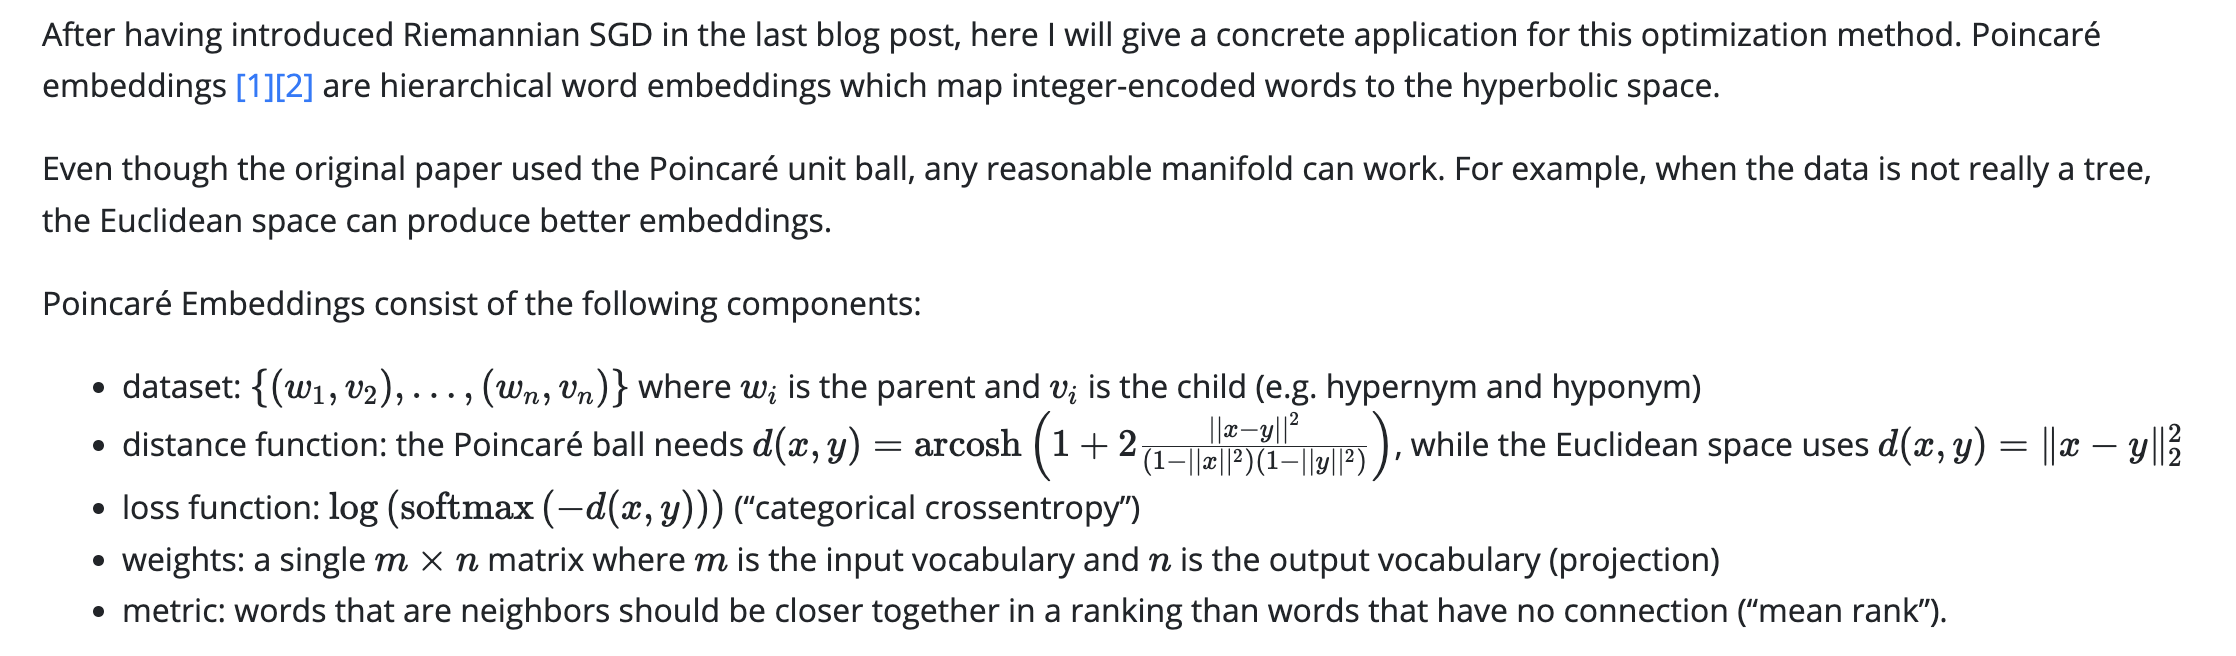

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
from torch.utils.data import DataLoader

# Data preprocessing
def normalize_concept(concept):
    concept = concept.lower()
    concept = re.sub(r'\W+', ' ', concept)
    return concept.strip()

hierarchical_data = [('South New Castle', 'Lawrence County'),
                     ('Entire small intestinal crypt of Lieberkühn', 'Small intestinal crypt of Lieberkühn'),
                     ('Fracture of metacarpal bone', 'Fracture of hand')]


hierarchical_data = [(normalize_concept(a), normalize_concept(b)) for a, b in hierarchical_data]
tokenized_concepts = [normalize_concept(concept).split() for concept_pair in hierarchical_data for concept in concept_pair]
unique_words = set(word for concept in tokenized_concepts for word in concept)

# Create word-to-index mapping
word_to_ix = {word: i for i, word in enumerate(unique_words)}
VOCAB_SIZE = len(unique_words)

# Hyperparameters
EMBEDDING_DIM = 50
CONTEXT_SIZE = 4
LEARNING_RATE = 0.001
EPOCHS = 50

# Model definition
class CombinedEmbeddings(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CombinedEmbeddings, self).__init__()
        self.poincare_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word2vec_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim * CONTEXT_SIZE, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, p_phrase1=None, p_phrase2=None, w2v_context=None):
        p_emb1 = p_emb2 = w2v_out = None

        if p_phrase1 is not None and p_phrase2 is not None:
            p_emb1 = self.poincare_embeddings(p_phrase1).mean(dim=1)
            p_emb2 = self.poincare_embeddings(p_phrase2).mean(dim=1)

        if w2v_context is not None:
            w2v_emb = self.word2vec_embeddings(w2v_context)
            w2v_emb = w2v_emb.view(1, -1)
            out = nn.functional.relu(self.linear1(w2v_emb))
            w2v_out = self.linear2(out)

        return p_emb1, p_emb2, w2v_out


model = CombinedEmbeddings(VOCAB_SIZE, EMBEDDING_DIM)
#optimizer = optim.RiemannianSGD(model.parameters(), lr=LEARNING_RATE) 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
poincare_loss_fn = nn.MSELoss()
word2vec_loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(EPOCHS):
    epoch_loss = 0

    # Train on hierarchical relationships
    for relation in hierarchical_data:
        optimizer.zero_grad()

        word1_ix = torch.tensor([word_to_ix[word] for word in relation[0].split()], dtype=torch.long).unsqueeze(0)
        word2_ix = torch.tensor([word_to_ix[word] for word in relation[1].split()], dtype=torch.long).unsqueeze(0)


        emb1, emb2, _ = model(word1_ix, word2_ix)

        poincare_loss = poincare_loss_fn(emb1, emb2)
        poincare_loss.backward()
        optimizer.step()

        epoch_loss += poincare_loss.item()

    # Train on tokenized concepts
    for concept in tokenized_concepts:
        for i, target_word in enumerate(concept):
            optimizer.zero_grad()

            context_indices = [i + x for x in range(-CONTEXT_SIZE // 2, CONTEXT_SIZE // 2 + 1) if x != 0 and 0 <= i + x < len(concept)]

            if len(context_indices) != CONTEXT_SIZE:
                continue

            context_words = [concept[ix] for ix in context_indices]
            context_word_ix = torch.tensor([word_to_ix[w] for w in context_words], dtype=torch.long)
            target_word_ix = torch.tensor([word_to_ix[target_word]], dtype=torch.long)

            _, _, w2v_out = model(w2v_context=context_word_ix)

            word2vec_loss = word2vec_loss_fn(w2v_out, target_word_ix)
            word2vec_loss.backward()
            optimizer.step()

            epoch_loss += word2vec_loss.item()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss}")


Epoch 1/50, Loss: 8.533564107492566
Epoch 2/50, Loss: 5.63734108582139
Epoch 3/50, Loss: 3.6862431298941374
Epoch 4/50, Loss: 2.4757229518145323
Epoch 5/50, Loss: 1.8356534540653229
Epoch 6/50, Loss: 1.5171467121690512
Epoch 7/50, Loss: 1.3592844409868121
Epoch 8/50, Loss: 1.2786624361760914
Epoch 9/50, Loss: 1.2348859808407724
Epoch 10/50, Loss: 1.208798720035702
Epoch 11/50, Loss: 1.1914487809408456
Epoch 12/50, Loss: 1.1786122444318607
Epoch 13/50, Loss: 1.1682325233705342
Epoch 14/50, Loss: 1.1592646093922667
Epoch 15/50, Loss: 1.1511521858046763
Epoch 16/50, Loss: 1.143584800302051
Epoch 17/50, Loss: 1.136380784388166
Epoch 18/50, Loss: 1.1294308499782346
Epoch 19/50, Loss: 1.1226654637721367
Epoch 20/50, Loss: 1.116039166750852
Epoch 21/50, Loss: 1.1095224676537327
Epoch 22/50, Loss: 1.1030945206875913
Epoch 23/50, Loss: 1.0967407124117017
Epoch 24/50, Loss: 1.0904511706903577
Epoch 25/50, Loss: 1.0842183289350942
Epoch 26/50, Loss: 1.078036584192887
Epoch 27/50, Loss: 1.07190232

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
from torch.utils.data import DataLoader

# Data preprocessing
def normalize_concept(concept):
    concept = concept.lower()
    concept = re.sub(r'\W+', ' ', concept)
    return concept.strip()

hierarchical_data = [('South New Castle', 'Lawrence County'),
                     ('Entire small intestinal crypt of Lieberkühn', 'Small intestinal crypt of Lieberkühn'),
                     ('Fracture of metacarpal bone', 'Fracture of hand')]

sentences = [
    'South New Castle',
    'Entire small intestinal crypt of Lieberkühn',
    'Fracture of metacarpal bone',
    'Small intestinal crypt of Lieberkühn',
    'Fracture of hand',
    'Lawrence County',
    "apple also makes the iphone",
    "banana is a fruit",
    "orange is a fruit",
    "android is a phone",
    "iphone is a phone",
]

hierarchical_data = [(normalize_concept(a), normalize_concept(b)) for a, b in hierarchical_data]
sentences = [normalize_concept(sentence) for sentence in sentences]

# Create word_to_ix dictionary
word_to_ix = {}
for relation in hierarchical_data:
    for phrase in relation:
        for word in phrase.split():
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)

for sentence in sentences:
    for word in sentence.split():
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

# Parameters
VOCAB_SIZE = len(word_to_ix)
CONTEXT_SIZE = 5  # The size of the context window
EMBEDDING_DIM = 5
HIDDEN_DIM = 128
LEARNING_RATE = 0.001
EPOCHS = 50

# Model definition
class CombinedModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(CombinedModel, self).__init__()
        self.poincare_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.word2vec_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.linear1 = nn.Linear(embedding_dim * CONTEXT_SIZE, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, p_phrase1=None, p_phrase2=None, w2v_context=None):
        p_emb1 = p_emb2 = w2v_out = None

        if p_phrase1 is not None and p_phrase2 is not None:
            p_emb1 = self.poincare_embeddings(p_phrase1).mean(dim=1)
            p_emb2 = self.poincare_embeddings(p_phrase2).mean(dim=1)
            return p_emb1, p_emb2, None

        if w2v_context is not None:
            w2v_emb = self.word2vec_embeddings(w2v_context)
            w2v_emb = w2v_emb.view(1, -1)
            w2v_out = nn.functional.relu(self.linear1(w2v_emb))
            w2v_out = self.linear2(w2v_out)
            return None, None, w2v_out
        

model = CombinedModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.SparseAdam(model.parameters(), lr=LEARNING_RATE)

poincare_loss_fn = nn.MSELoss()
word2vec_loss_fn = nn.CrossEntropyLoss()

__main__.CombinedModel

In [16]:
VOCAB_SIZE

27

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Data
hierarchical_data = [
    ('South New Castle', 'Lawrence County'),
    ('Entire small intestinal crypt of Lieberkühn', 'Small intestinal crypt of Lieberkühn'),
    ('Fracture of metacarpal bone', 'Fracture of hand')
]

sentences = [
    'South New Castle',
    'Entire small intestinal crypt of Lieberkühn',
    'Fracture of metacarpal bone',
    'Small intestinal crypt of Lieberkühn',
    'Fracture of hand',
    'Lawrence County',
    "apple also makes the iphone",
    "banana is a fruit",
    "orange is a fruit",
    "android is a phone",
    "iphone is a phone",
]

# Create word_to_ix dictionary
word_to_ix = {}
for relation in hierarchical_data:
    for phrase in relation:
        for word in phrase.split():
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)

for sentence in sentences:
    for word in sentence.split():
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

# Parameters
VOCAB_SIZE = len(word_to_ix)
CONTEXT_SIZE = 5  # The size of the context window
EMBEDDING_DIM = 5
HIDDEN_DIM = 128

class CombinedModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(CombinedModel, self).__init__()
        self.poincare_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.word2vec_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.linear1 = nn.Linear(embedding_dim * (CONTEXT_SIZE - 1), hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, p_phrase1=None, p_phrase2=None, w2v_context=None):
        if p_phrase1 is not None and p_phrase2 is not None:
            emb1 = self.poincare_embeddings(p_phrase1).sum(dim=1)
            emb2 = self.poincare_embeddings(p_phrase2).sum(dim=1)
            return emb1, emb2, None

        if w2v_context is not None:
            w2v_emb = self.word2vec_embeddings(w2v_context)
            w2v_emb = w2v_emb.view(1, -1)
            out = nn.functional.relu(self.linear1(w2v_emb))
            out = self.linear2(out)
            return None, None, out

model = CombinedModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.SparseAdam(model.parameters(), lr=0.01)

poincare_loss_fn = nn.MSELoss()
word2vec_loss_fn = nn.CrossEntropyLoss()

# Training loop
n_epochs = 100

for epoch in range(n_epochs):
    epoch_loss = 0.0

    # Train on hierarchical_data
    for relation in hierarchical_data:
        optimizer.zero_grad()

        word1_ix = torch.tensor([word_to_ix[word] for word in relation[0].split()], dtype=torch.long).unsqueeze(0)
        word2_ix = torch.tensor([word_to_ix[word] for word in relation[1].split()], dtype=torch.long).unsqueeze(0)

        emb1, emb2, _ = model(p_phrase1=word1_ix, p_phrase2=word2_ix)

        poincare_loss = poincare_loss_fn(emb1, emb2)
        poincare_loss.backward()
        optimizer.step()
        epoch_loss += poincare_loss.item()

    # Train on sentences
    for sentence in sentences:
        words = sentence.split()
        tokenized_sentence = [word_to_ix[word] for word in words]

        for i, target_word in enumerate(tokenized_sentence):
            optimizer.zero_grad()

            context_indices = [i + x for x in range(-CONTEXT_SIZE // 2, CONTEXT_SIZE // 2 + 1) if x != 0 and 0 <= i + x < len(tokenized_sentence)]
            context_words = [tokenized_sentence[ix] for ix in context_indices]
            context_word_ix = torch.tensor(context_words, dtype=torch.long)
            target_word_ix = torch.tensor([target_word], dtype=torch.long)

            _, _, w2v_out = model(w2v_context=context_word_ix)

            word2vec_loss = word2vec_loss_fn(w2v_out, target_word_ix)
            word2vec_loss.backward()
            optimizer.step()
            epoch_loss += word2vec_loss.item()

    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss}")






RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x10 and 20x128)